In [1]:
import javabridge
import bioformats

javabridge.start_vm(class_path=bioformats.JARS)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [11]:
from scipy.signal import find_peaks

In [3]:
from ipywidgets import interact, IntSlider
from IPython.display import display

In [4]:
def create_circular_mask(h, w, center=None, radius=None):
    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    mask = dist_from_center <= radius
    return mask.astype(np.uint8)

In [5]:
# fp = "20250908/20250908/A1/hcc_04.vsi"
fp = "20250908/20250429/A1/231_A1-1_001.vsi"
metadata =  bioformats.OMEXML(bioformats.get_omexml_metadata(path=fp))
T = metadata.image().Pixels.SizeT
W = metadata.image().Pixels.SizeX
H = metadata.image().Pixels.SizeY
timelapse = np.stack([bioformats.load_image(fp, t=t) for t in range(T)])
# RECT = (200, 200, 100, 100)
RECT = (300, 300, 400, 400)

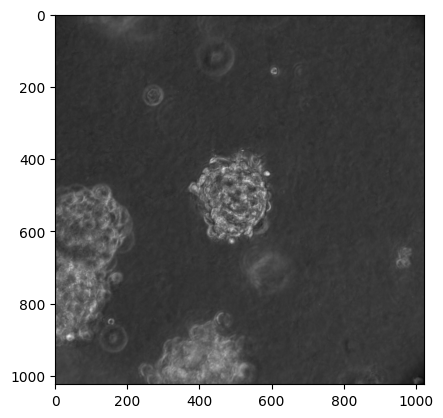

In [6]:
plt.imshow(timelapse[0], cmap="gray")

In [7]:
def pol2cart(phi, rho, dst, center, maxRadius, flags):
    dstx, dsty = dst
    Kangle = dsty / (2 * np.pi)
    angleRad = phi / Kangle

    if flags & cv2.WARP_POLAR_LOG:
        Klog = dstx / np.log(maxRadius)
        magnitude = np.exp(rho / Klog)
    else:
        Klin = dstx / maxRadius
        magnitude = rho / Klin

    cx, cy = center
    x = (np.round(cx + magnitude * np.cos(angleRad)))
    y = (np.round(cy + magnitude * np.sin(angleRad)))
    return x, y


In [18]:
def update(value):
    frame = timelapse[value, :, :]
    bgr_im = cv2.cvtColor((frame * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
    mask = np.zeros((W, H), np.uint8)
    cv2.grabCut(
        img=bgr_im,
        mask=mask,
        rect=RECT,
        bgdModel=np.zeros((1, 65), np.float64),
        fgdModel=np.zeros((1, 65), np.float64),
        iterCount=5,
        mode=cv2.GC_INIT_WITH_RECT
    )
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    closed = cv2.morphologyEx(mask2, cv2.MORPH_CLOSE, kernel=create_circular_mask(9, 9))
    
    M = cv2.moments(closed)
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])
    
    polW, polH = (200, 360) 
    pol = cv2.warpPolar(closed, (polW, polH), (cx, cy), 200, cv2.WARP_POLAR_LOG)
    ds = polW - 1 - np.argmax(pol[:, ::-1], axis=1)
    peaks, _ = find_peaks(ds, prominence=2)
    bdry_x, bdry_y = pol2cart(np.arange(polH), ds, (polW, polH), (cx, cy), 200, cv2.WARP_POLAR_LOG)
    peak_x, peak_y = pol2cart(peaks, ds[peaks], (polW, polH), (cx, cy), 200, cv2.WARP_POLAR_LOG)
    # fig = plt.gcf()
    # fig.set_size_inches(20, 10)
    # plt.subplot(3, 2, 1).imshow(frame, cmap="gray")
    # plt.subplot(3, 2, 2).imshow(mask2, cmap="gray")
    # plt.subplot(3, 2, 3).imshow(closed, cmap="gray")

    # plt.subplot(3, 2, 1).plot(bdry_x, bdry_y)
    # plt.subplot(3, 2, 2).plot(bdry_x, bdry_y)
    # plt.subplot(3, 2, 3).plot(bdry_x, bdry_y)
    # # plt.subplot(3, 2, 4).imshow(bdry_mask, cmap="gray")
    # # plt.subplot(3, 2, 3, projection="polar").plot(np.arange(360)*np.pi/180, ds)
    
    # plt.subplot(3, 2, (5, 6)).imshow(pol.T, origin="lower", cmap="gray")
    # plt.subplot(3, 2, (5, 6)).plot(ds)

    spnr, spnc = 2, 2
    plt.subplot(spnr, spnc, 1).imshow(frame, cmap="gray")
    plt.subplot(spnr, spnc, 1).set_xlim(RECT[0], RECT[0]+RECT[2])
    plt.subplot(spnr, spnc, 1).set_ylim(RECT[1], RECT[1]+RECT[3])
    plt.subplot(spnr, spnc, 2).imshow(frame, cmap="gray")
    plt.subplot(spnr, spnc, 2).plot(bdry_x, bdry_y)
    plt.subplot(spnr, spnc, 2).scatter(peak_x, peak_y, color="r")
    plt.subplot(spnr, spnc, 2).set_xlim(RECT[0], RECT[0]+RECT[2])
    plt.subplot(spnr, spnc, 2).set_ylim(RECT[1], RECT[1]+RECT[3])
    plt.subplot(spnr, spnc, (3, 4)).plot(ds)
    plt.subplot(spnr, spnc, (3, 4)).scatter(peaks, ds[peaks], color="r")


    # plt.subplot(spnr, spnc,2).imshow(frame*closed, cmap="gray")
    # plt.subplot(spnr, spnc,2).set_xlim(200, 300)
    # plt.subplot(spnr, spnc,2).set_ylim(300, 200)

    


slider = IntSlider(min=0, max=T-1, step=1, value=0, description="t")
interact(update, value=slider)

interactive(children=(IntSlider(value=0, description='t', max=60), Output()), _dom_classes=('widget-interact',…

<function __main__.update(value)>

In [9]:
# gray_im = cv2.cvtColor(bgr_im, cv2.COLOR_BGR2GRAY)
# ret, thresh = cv2.threshold(cv2.cvtColor(bgr_im, cv2.COLOR_BGR2GRAY), 127, 255, 0)
# contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# plt.imshow(cv2.drawContours(bgr_im, contours, -1, (0,255,0), 3), cmap="gray")

#plt.imshow(cv2.Canny(bgr_im,100,200), cmap="gray")

In [10]:
# javabridge.kill_vm()